## backprop

1. 向前传播：按顺序（从输入层到输出层）计算和储存神经网络中每层的结果
2. 反向传播：计算神经网络参数梯度的方法，根据微积分中的链式规则，按相反的顺序从输出层到输入层遍历网络  
储存了计算某些参数梯度时所需的任何中间变量
3. 训练神经网络：向前传播和反向传播**相互依赖**  
    - 在训练神经⽹络时，在初始化模型参数后，我们交替使⽤前向传播和反向传播，利⽤反向传播给出的梯度来更新模型参数
    - 反向传播**重复利⽤**前向传播中存储的中间值，以避免重复计算
    - **需要保留中间值**，直到反向传播完成——故**训练比预测需要更多的内存**
    - 这些中间值的⼤⼩与**⽹络层的数量和批量的⼤⼩**⼤致成正⽐

### 练习

1. 假设一些标量函数$\mathbf{X}$的输入$\mathbf{X}$是$n \times m$矩阵。$f$相对于$\mathbf{X}$的梯度维数是多少？
1. 向本节中描述的模型的隐藏层添加偏置项（不需要在正则化项中包含偏置项）。
    1. 画出相应的计算图。
    1. 推导正向和反向传播方程。
1. 计算本节所描述的模型，用于训练和预测的内存占用。
1. 假设想计算二阶导数。计算图发生了什么？预计计算需要多长时间？
1. 假设计算图对当前拥有的GPU来说太大了。
    1. 请试着把它划分到多个GPU上。
    1. 与小批量训练相比，有哪些优点和缺点？

### 回答
1. 维数与矩阵$X$相同
3. 主要是：权重、偏置、中间变量
4. 需要再构造一个以一阶导数为正向传播的计算图，然后再反向传播求导
5. 把网络按三种方式划分到GPU上，**网络**并行、**分层**并行、**数据**并行
    - 优点：多个GPU集群可以训练较大的模型（前两种）以及更快的训练模型（第三种）
    - 缺点：可以因为节点间通信的限制导致速度不够快

## numerical stability and initial

### 神经网络的梯度
- 考虑如下有$d$层的神经网络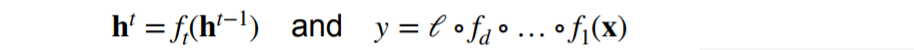
- 计算损失$\ell$关于参数$\mathbf{W}_t$的梯度（其中$h^d$是向量）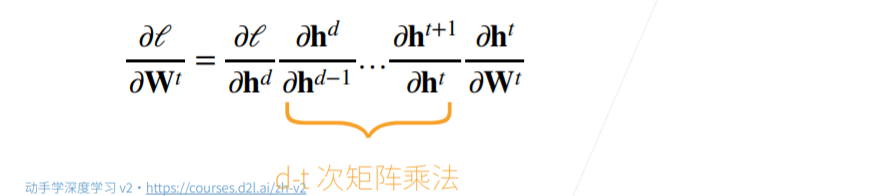
向量对向量求导得到的是矩阵

### 数值稳定性的常见两个问题
- **梯度爆炸**
    - 值超出值域（infinity）
        - 对于16位浮点数尤为严重（数值区间6e-5 - 6e4）
    - 对学习率敏感
        - 如果学习率太大 -> 大参数值 -> 更大的梯度
        - 如果学习率太小 -> 训练无进展
        - 可能需要在训练过程中不断调整学习率
- **梯度消失**
    - 梯度值变为0
        - 对16位浮点数尤为严重
    - 训练没有进展
        - 不管如何选择学习率
    - 对于底部层尤为严重（反向传播）
        - 仅仅顶部层训练的好
        - 无法让神经网络更深
- 例子：MLP
    - 加入如下MLP（为了简单省略偏移）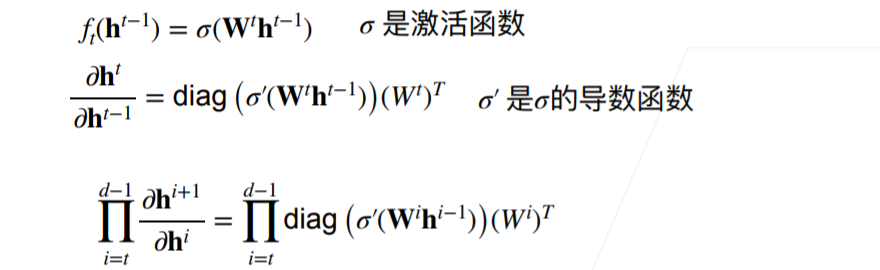
    - 梯度爆炸
        - 使用ReLU作为激活函数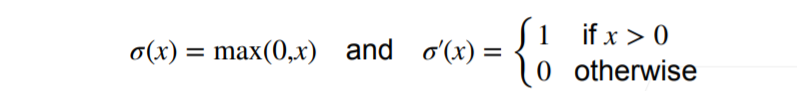
        - $\prod_{i=t}^{d-1} \frac{\partial h^{i+1}}{\partial h^i} = \prod_{i=t}^{d-1} \text{diag}(\sigma'(\mathbf{W}^i h^{i-1})) (\mathbf{W}^i)^{T}
$的一些元素会来自于$\prod_{i=t}^{d-1}(\mathbf{W}^i)^{T}$
        - 如果$d-t$很大，值将很大
    - 梯度消失
        - 使用sigmoid作为激活函数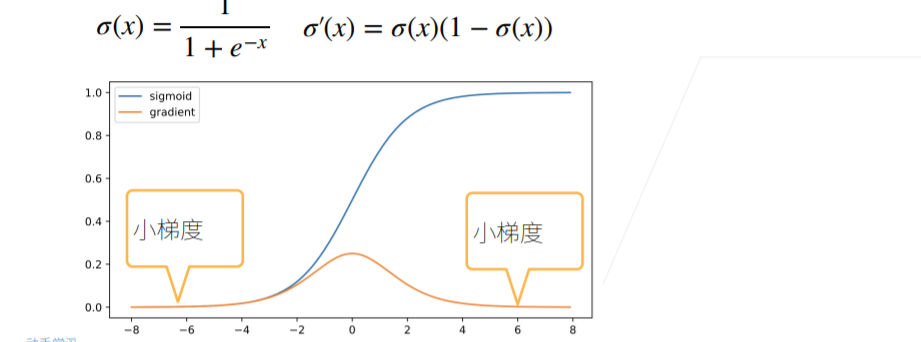
        - $\prod_{i=t}^{d-1} \frac{\partial h^{i+1}}{\partial h^i} = \prod_{i=t}^{d-1} \text{diag}(\sigma'(\mathbf{W}^i h^{i-1})) (\mathbf{W}^i)^{T}
$的一些元素会来自于$\prod_{i=t}^{d-1}(\mathbf{W}^i)^{T}$的元素值是$d-t$个小数值的乘积

### 总结
- 当数值过大或过小时会导致数值问题
- 常发生在深度模型中，因为其会对$n$个数累乘


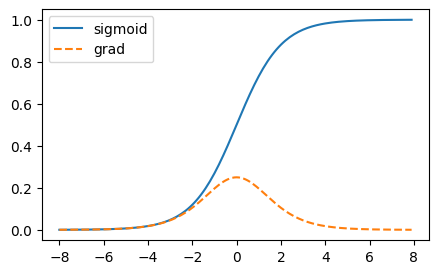

In [5]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-8., 8., 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(y))

plt.figure(figsize=(5, 3))
plt.plot(x.detach().numpy(), y.detach().numpy(), '-', label='sigmoid')
plt.plot(x.detach().numpy(), x.grad.numpy(), '--', label='grad')
plt.legend()
plt.show()

In [12]:
M = torch.normal(0, 1, (4, 4))
print(M)
for i in range(100):
    M = torch.mm(M, torch.normal(0, 1, size=(4, 4)))
print('乘以100个矩阵后\n', M)

tensor([[ 1.7421,  0.0858,  0.8867,  0.3435],
        [-0.8571, -1.4097,  0.7690,  1.0150],
        [-0.5860, -0.3520,  0.8575, -0.8478],
        [ 0.7298,  1.0118, -1.9229, -2.0268]])
乘以100个矩阵后
 tensor([[-3.8877e+25,  8.8126e+25, -1.0036e+26, -3.2282e+25],
        [-2.6857e+25,  6.0880e+25, -6.9332e+25, -2.2302e+25],
        [ 1.1659e+25, -2.6428e+25,  3.0097e+25,  9.6811e+24],
        [ 1.1898e+24, -2.6969e+24,  3.0712e+24,  9.8792e+23]])


## 让训练更加稳定

### 让训练更加稳定
- 目标：让梯度值在合理的范围内
    -  如[1e-6, 1e3]
- 将乘法变加法
    - ResNet，LSTM
- 归一化
    - 梯度归一化，梯度裁剪
- 合理的权重初始和激活函数

### 让每层的方差是一个常数
- 将每层的输出和梯度都看成随机变量
- 让它们的**均值和方差都保持一致**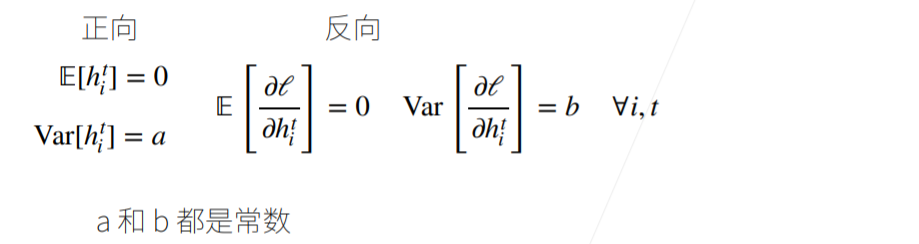

### 权重初始化
- 在合理值区间内随机初始参数
- 训练开始时更容易有数值不稳定
    - 远离最优解的地方损失函数表面可能很复杂
    - 最优解附近表面会比较平
- 使用$N(0, 0.01)$来初始可能对小网络没问题，但不能保证深度神经网络
- **随机初始化是保证在进行优化前打破对称性的关键**

### 例子：MLP
- 假设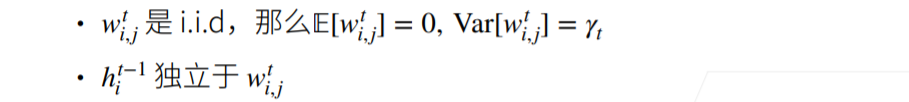
- 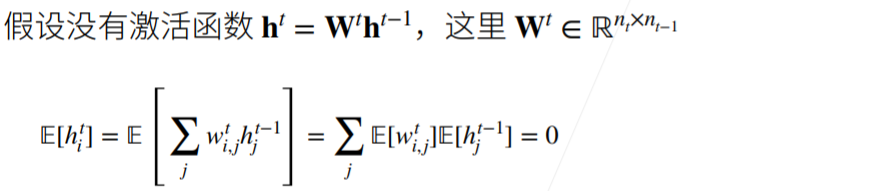

### 正向方差
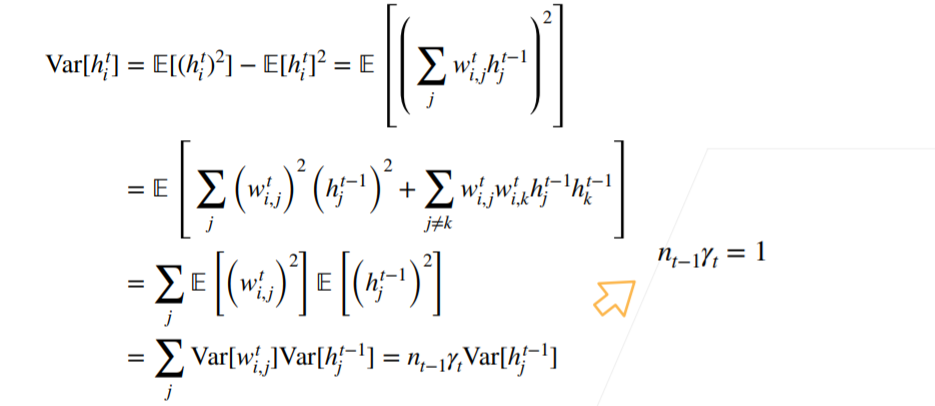

### 反向均值和方差
- 和正向情况类似
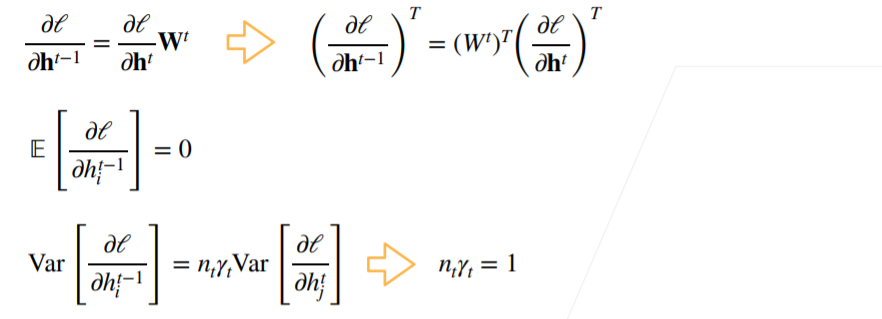

### **Xavier初始**
- 难以满足$n_{t-1}\gamma_t = 1$和$n_t\gamma_t = 1$
- 
$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ 或等价于 }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}.
\end{aligned}
$$
$$
U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right).
$$
- 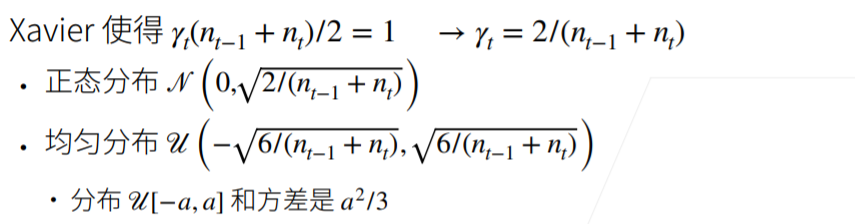
- **适配权重形状变化**，特别是$n_t$
- Xavier初始化表明，对于每一层，**输出的方差不受输入数量的影响**，**任何梯度的方差不受输出数量的影响**

### 假设**线性**的激活函数（简单起见）
- 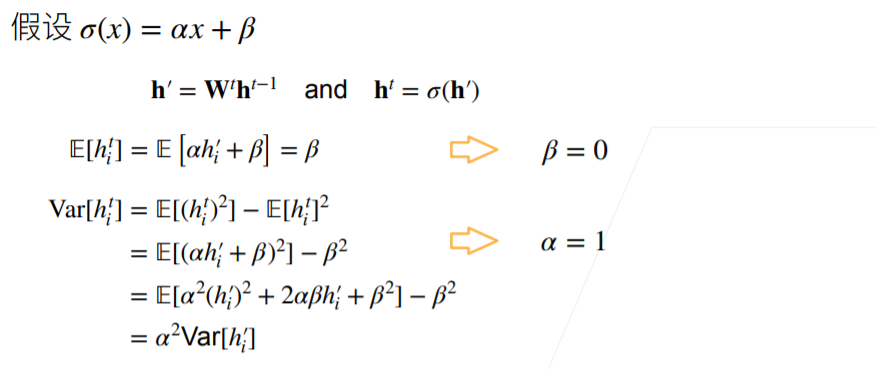
- 反向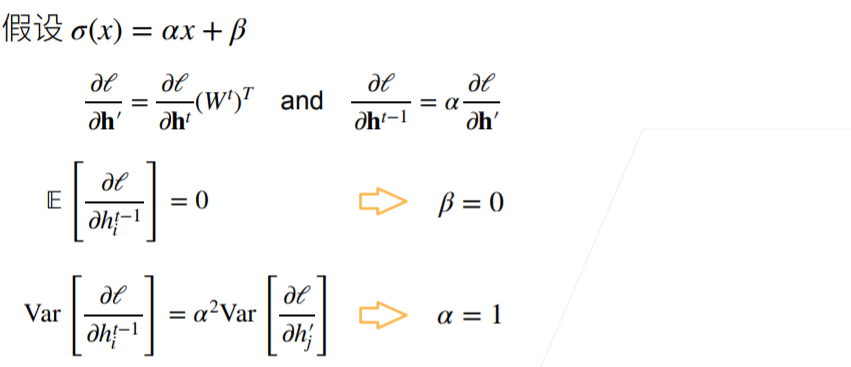

### 检查常用激活函数
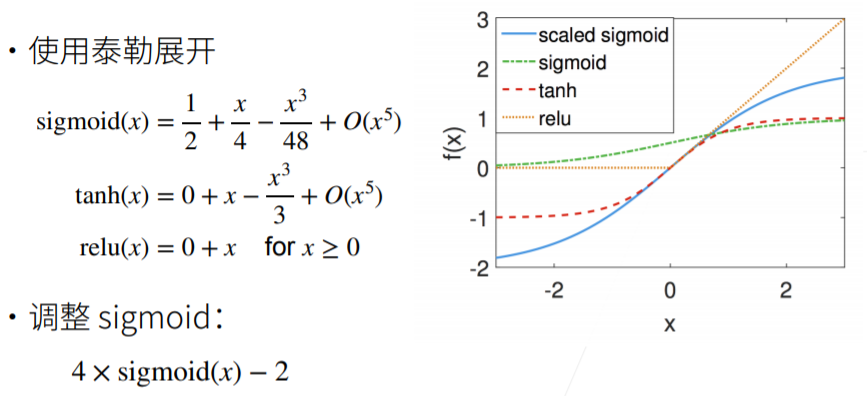

### 总结
- **合理的权重初始值和激活函数的选取**可以提升数值稳定性

### 练习
1. 我们是否可以将线性回归或softmax回归中的所有权重参数初始化为相同的值？
- 当所有权重参数具有**相同的初始值**时，模型在进行反向传播和参数更新时，**每个权重都会以相同的方式更新**。这种情况下，每个特征在模型中的作用是相同的，无法体现特征之间的差异和重要性。这可能导致模型的学习能力受限，难以捕捉到数据中的复杂关系。

- 相反，使用不同的初始值可以帮助模型在训练过程中探索不同的权重组合，以更好地适应数据。常用的初始化方法包括**随机初始化**（如从均匀分布或正态分布中随机采样）和**Xavier初始化**（**根据输入和输出维度自适应地选择合适的初始范围**）

- 因此，为了有效地训练线性回归或softmax回归模型，通常建议对权重参数**进行适当的初始化**，以便在训练过程中提供足够的表达能力和灵活性

2. 出现nan或inf的解决办法 
    - 合理初始化权重、激活函数不要选错、学习率不要选太大
    - 将学习率调小，直到nan或inf不出现
    - 权重的初始，选方差小的，直到不出现，再慢慢放大

3. sigmoid激活函数能引起梯度消失，用ReLU来替代sigmoid可以降低梯度消失的概率，但是不能一定解决梯度消失问题
    - 梯度消失也可能是其他原因引起的
    